<a href="https://colab.research.google.com/github/andresmauriciogomezr/deblurGAN_OCR_enhancement/blob/main/GAN_Entrenar_V6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip install pytorch-msssim

In [ ]:
from google.colab import drive
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
os.chdir('gdrive/My Drive/Ciel/LectorCedula/Autoencoder/Entrenamiento')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision.io import read_image
from PIL import Image
import pytesseract

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [ ]:
class ReductorRuidoDatasetTest(Dataset):


  def __init__(self, carpeta_datos):

    super().__init__()

    # define el nombre de la carpeta necesaria
    self.carpeta_entrenamiento = f"{carpeta_datos}/test"

    # se listan las imagenes presentes la carpeta
    self.lista_archivos = os.listdir(self.carpeta_entrenamiento)




  def __getitem__(self,idx):

    # Se obtiene el registro correspondiente al index correspondiente
    nombre_registro = self.lista_archivos[idx]

    ruta_imagen = f"{self.carpeta_entrenamiento}/{nombre_registro}"

    # Realiza una normalización buscando estabilidad numerica
    imagen_ruido = read_image(ruta_imagen).float() / 255.0



    # convert images to numpy objects
    imagen_ruido = imagen_ruido.numpy()

    # # Se realiza redimensión si es necesario
    # if imagen_limpia.shape[1] != 258:
    imagen_ruido = torch.from_numpy(transform.resize(imagen_ruido, (1, 50, 200)))


    # if imagen_ruido.shape[1:] != (34, 181):
    #   # Calcula la cantidad de padding necesaria en cada dimensión
    #   pad_height = max(0, 34 - imagen_ruido.shape[1])
    #   pad_width = max(0, 181 - imagen_ruido.shape[2])

    #   # Agrega padding a la imagen
    #   padding = ((0, 0), (0, pad_height), (0, pad_width))
    #   imagen_ruido = np.pad(imagen_ruido, padding, mode='constant')

    #   # Convierte de nuevo a tensor de pytorch
    #   imagen_ruido = torch.from_numpy(imagen_ruido)

    # Devuelve la imagen, y una matriz de ceros que en realidad no se usa pero buscando limpieza en el codigo más adelante
    return imagen_ruido, torch.zeros(1, 258, 540)

  def __len__(self):
    return len(self.lista_archivos)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
#from pytorch_msssim import SSIM
#from pytorch_msssim import SSIM, MS_SSIM

class CombinedLoss(nn.Module):
    """
    Combina MSE y (1 - SSIM) para balancear reconstrucción global y detalles.
    """
    def __init__(self, alpha=0.8):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        # O puedes usar MS_SSIM
        self.ssim = SSIM(data_range=1.0, size_average=True, channel=1)

    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        ssim_loss = 1 - self.ssim(pred, target)  # SSIM -> valor en [0,1], restamos a 1
        return self.alpha * ssim_loss + (1 - self.alpha) * mse_loss


In [ ]:
from torchvision.transforms import v2 as T


transforms = []
# transforms.append(T.RandomHorizontalFlip(0.5))
transforms.append(T.ToDtype(torch.float, scale=True))
# transforms.append(T.ToPureTensor())
transformaciones =  T.Compose(transforms)

class ReductorRuidoDataset(Dataset):


  def __init__(self, carpeta_datos):

    super().__init__()

    # se listan las imagenes presentes la carpeta
    self.lista_archivos = os.listdir(f"{carpeta_datos}/train")

    # define el nombre de la carpeta necesaria
    self.carpeta_entrenamiento = f"{carpeta_datos}/train"
    self.carpeta_entrenamiento_limpio = f"{carpeta_datos}/train_clean"


  def __getitem__(self,idx):

    # Se obtiene el registro correspondiente al index correspondiente
    nombre_registro = self.lista_archivos[idx]

    ruta_imagen = f"{self.carpeta_entrenamiento}/{nombre_registro}"
    ruta_imagen_limpia = f"{self.carpeta_entrenamiento_limpio}/{nombre_registro}"

    # Realiza una normalización buscando estabilidad numerica
    imagen_ruido = read_image(ruta_imagen).float() / 255.0
    imagen_limpia = read_image(ruta_imagen_limpia).float() / 255.0

    # convert images to numpy objects
    imagen_ruido = imagen_ruido.numpy()
    imagen_limpia = imagen_limpia.numpy()

    # # Se realiza redimensión si es necesario
    # if imagen_limpia.shape[1] != 258:
    # imagen_ruido = torch.from_numpy(transform.resize(imagen_ruido, (1, 34, 181)))
    # imagen_limpia = torch.from_numpy(transform.resize(imagen_limpia, (1, 34, 181)))

    # if imagen_ruido's shape is different of (50,200), increase its size by adding padding




    imagen_ruido = torch.from_numpy(transform.resize(imagen_ruido, (1, 50, 200)))
    imagen_limpia = torch.from_numpy(transform.resize(imagen_limpia, (1, 50, 200)))

    # if imagen_ruido.shape[1:] != (34, 181):
    #   # Calcula la cantidad de padding necesaria en cada dimensión
    #   pad_height = max(0, 34 - imagen_ruido.shape[1])
    #   pad_width = max(0, 181 - imagen_ruido.shape[2])

    #   # Agrega padding a la imagen
    #   padding = ((0, 0), (0, pad_height), (0, pad_width))
    #   imagen_ruido = np.pad(imagen_ruido, padding, mode='constant')
    #   imagen_limpia = np.pad(imagen_limpia, padding, mode='constant')

    #   # Convierte de nuevo a tensor de pytorch
    #   imagen_ruido = torch.from_numpy(imagen_ruido)
    #   imagen_limpia = torch.from_numpy(imagen_limpia)



    # Genera un numero pseudo aleatorio entre 0 y 1
    random_value = torch.randint(0, 2, (1, 1, 1))

    # Se realiza un flip a la imaagen cuando el aleatorio es 1, así se entrega diferente versión de la imagen a través de las epocas
    if random_value == 1:
      imagen_ruido = transformaciones(imagen_ruido)
      imagen_limpia = transformaciones(imagen_limpia)

    return imagen_ruido, imagen_limpia

  def __len__(self):
    return len(self.lista_archivos)



torch.Size([64, 1, 50, 200])


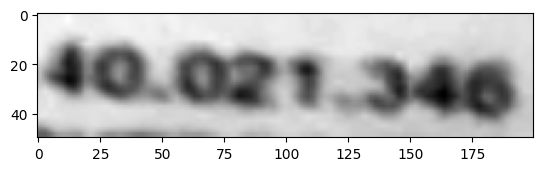

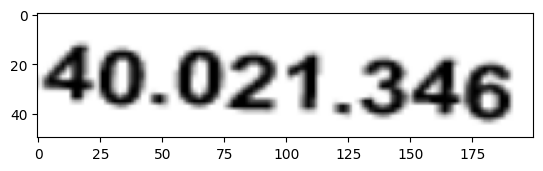

In [ ]:
dataset_ = ReductorRuidoDataset("Dataset")
data_loader_entrenamiento = DataLoader(dataset_, batch_size=64, shuffle=True)

# dataset_ = ReductorRuidoDatasetTest("Dataset")
# data_loader_pruebas = DataLoader(dataset_, batch_size=2, shuffle=True)

# model = ConvAutoencoder()
# model = model.to(device)
# model.eval()
# with torch.no_grad():
for imagen_ruido, imagen_limpia in data_loader_entrenamiento:

  print(imagen_ruido.shape)

  # plot imagen_ruido
  plt.imshow(imagen_ruido[0][0], cmap='gray')
  plt.show()

  # plot imagen_limpia
  plt.imshow(imagen_limpia[0][0], cmap='gray')
  plt.show()




  # print(noisy_img.max(), noisy_img.min())
  # noisy_img = noisy_img.to(device)

  # output = model(noisy_img)

  # print(output[0][0].shape)

  break

In [ ]:
import torch
import torch.nn as nn

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # ENCODER
        self.encoder = nn.Sequential(
            # Conv -> (batch, 32, 34, 181)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(True),
            nn.LeakyReLU(True),

            # MaxPool sin padding para simplificar la decodificación
            # -> (batch, 32, 17, 90)
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            # Conv -> (batch, 32, 17, 90)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(True),
            # nn.ReLU(True),

            nn.Flatten()  # -> (batch, 32*17*90) = (batch, 48960)
        )

        # DECODER
        self.decoder = nn.Sequential(
            # Volvemos a (batch, 32, 17, 90)
            nn.Unflatten(dim=1, unflattened_size=(32, 17, 90)),

            # ConvTranspose para "deshacer" el MaxPool:
            # Con kernel_size=2, stride=2, padding=0 y output_padding=(0,1)
            # pasamos de (17, 90) a (34, 181)
            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=32,
                kernel_size=2,
                stride=2,
                padding=0,
                output_padding=(0, 1)
            ),
            nn.LeakyReLU(True),
            # nn.ReLU(True),

            # Última convolución para volver a un solo canal con el tamaño deseado
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
import torch
import torch.nn as nn

class ConvAutoencoderSkip(nn.Module):
    def __init__(self):
        super(ConvAutoencoderSkip, self).__init__()

        # Bloque de codificación 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.LeakyReLU(inplace=True)

        # Pooling para reducir dimensiones (se perderá algo de información fina)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # De (34,181) a (17,90)

        # Bloque de codificación 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.LeakyReLU(inplace=True)

        # NOTA: Se conserva la forma (32,17,90), que se aplana en el proceso pero luego se "desaplana"
        # para recuperar la estructura espacial.

        # Decoder: primero se reconstruye la forma espacial original con un ConvTranspose2d
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 17, 90))
        self.deconv = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=32,
            kernel_size=2,
            stride=2,
            padding=0,
            output_padding=(0, 1)  # Para obtener (34,181)
        )
        self.act3 = nn.LeakyReLU(inplace=True)

        # La conexión "skip" se aplicará sumando la salida del primer bloque (antes del pooling)
        # a la salida del deconv.

        # Capa final para reconstruir el canal de salida
        self.conv_final = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        # Bloque 1: se guarda para la skip connection
        x1 = self.act1(self.conv1(x))           # (batch, 32, 34, 181)
        x_pool = self.pool(x1)                   # (batch, 32, 17, 90)

        # Bloque 2
        x2 = self.act2(self.conv2(x_pool))       # (batch, 32, 17, 90)
        # Se aplana la salida (aunque en este ejemplo lo "desaplanamos" inmediatamente)
        x_flat = torch.flatten(x2, start_dim=1)

        # Decoder
        x_unflat = self.unflatten(x_flat)        # (batch, 32, 17, 90)
        x_deconv = self.act3(self.deconv(x_unflat))  # (batch, 32, 34, 181)

        # Skip connection: se suma la información del primer bloque
        x_sum = x_deconv + x1                    # (batch, 32, 34, 181)

        # Capa final
        x_out = self.conv_final(x_sum)           # (batch, 1, 34, 181)
        x_out = self.out_act(x_out)
        return x_out


In [ ]:
def evaluar(modelo, data_loader_pruebas):
  criterion = nn.MSELoss()

  modelo.eval()
  with torch.no_grad():

    epoch_loss = 0
    for imagen_ruido, imagen_limpia in data_loader_pruebas:
      imagen_ruido = imagen_ruido.to(device)
      imagen_limpia = imagen_limpia.to(device)

      salida = modelo(imagen_ruido)
      loss = criterion(salida, imagen_limpia)

      epoch_loss += loss.item()

    loss_promedio = epoch_loss / len(data_loader_pruebas)

    return loss_promedio

In [ ]:
# Se crea la instancia del dataset y dataloader usados para el entrenamiento
dataset_ = ReductorRuidoDataset("Dataset")

# Se establece el criterio de partición
indices = torch.randperm(len(dataset_)).tolist()
split = int(0.85 * len(indices))

# Segmenta el dataset 85% para entrenamiento y 15% para validación
dataset_entrenamiento = torch.utils.data.Subset(dataset_, indices[:split])
dataset_val = torch.utils.data.Subset(dataset_, indices[split:])

Epoch [1/100]  Loss_G: 2.9498  Loss_D: 0.4240
Epoch [2/100]  Loss_G: 1.8872  Loss_D: 0.2688
Epoch [3/100]  Loss_G: 1.8350  Loss_D: 0.2466
Epoch [4/100]  Loss_G: 1.8335  Loss_D: 0.2603
Epoch [5/100]  Loss_G: 1.8216  Loss_D: 0.2292
Epoch [6/100]  Loss_G: 1.8219  Loss_D: 0.2295
Epoch [7/100]  Loss_G: 1.8148  Loss_D: 0.2380
Epoch [8/100]  Loss_G: 1.7613  Loss_D: 0.2068
Epoch [9/100]  Loss_G: 1.8010  Loss_D: 0.2070
Epoch [10/100]  Loss_G: 1.7660  Loss_D: 0.2113
Epoch [11/100]  Loss_G: 1.8012  Loss_D: 0.1994
Epoch [12/100]  Loss_G: 1.8040  Loss_D: 0.1971
Epoch [13/100]  Loss_G: 1.8168  Loss_D: 0.1930
Epoch [14/100]  Loss_G: 1.7928  Loss_D: 0.1934
Epoch [15/100]  Loss_G: 1.8203  Loss_D: 0.2372
Epoch [16/100]  Loss_G: 1.7031  Loss_D: 0.1800
Epoch [17/100]  Loss_G: 1.7637  Loss_D: 0.1747
Epoch [18/100]  Loss_G: 1.7445  Loss_D: 0.1799
Epoch [19/100]  Loss_G: 1.7366  Loss_D: 0.1869
Epoch [20/100]  Loss_G: 1.7279  Loss_D: 0.1895
Epoch [21/100]  Loss_G: 1.7632  Loss_D: 0.1626
Epoch [22/100]  Loss_G

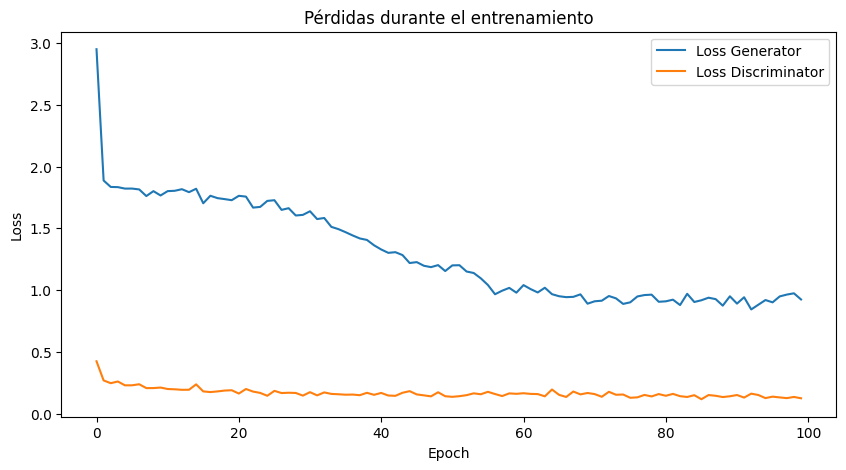

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pytorch_msssim import SSIM, MS_SSIM

# ---------------------------
# Bloque Residual
# ---------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

# ---------------------------
# Generator (DeblurGAN simplificado) para imágenes 50x200
# ---------------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Capa inicial: extrae características preservando la resolución original.
        # Entrada: (1, 50, 200) -> Salida: (64, 50, 200)
        self.initial = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Downsampling: reduce la resolución sin perder demasiados detalles.
        # De (64, 50, 200) a (128, 25, 100)
        self.down = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Bloques residuales para refinar la representación.
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(128) for _ in range(4)]
        )

        # Upsampling: se desea recuperar la resolución original.
        # Fórmula: output_size = (input - 1) * stride - 2 * padding + kernel_size + output_padding
        # Para la altura:
        #   (25 - 1)*2 - 2*1 + 3 + output_padding_h = 48 - 2 + 3 + output_padding_h = 49 + output_padding_h
        # Queremos 50 => output_padding_h = 1
        # Para el ancho:
        #   (100 - 1)*2 - 2*1 + 3 + output_padding_w = 198 - 2 + 3 + output_padding_w = 199 + output_padding_w
        # Queremos 200 => output_padding_w = 1
        # Así, la capa de upsampling transforma (128, 25, 100) en (64, 50, 200)
        self.up = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Skip connection global: se suman los detalles extraídos en la capa inicial
        # con la salida del upsampling.
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=7, stride=1, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_initial = self.initial(x)     # (64, 50, 200)
        x_down = self.down(x_initial)    # (128, 25, 100)
        x_res = self.res_blocks(x_down)  # (128, 25, 100)
        x_up = self.up(x_res)            # (64, 50, 200)
        x_comb = x_up + x_initial        # Skip connection: (64, 50, 200)
        out = self.final(x_comb)         # (1, 50, 200)
        return out

# ---------------------------
# Discriminator (PatchGAN) para imágenes 50x200
# ---------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # La arquitectura se mantiene similar, pero se actualizan los comentarios
        # para reflejar las dimensiones con la nueva resolución.
        self.net = nn.Sequential(
            # Capa 1: de (1, 50, 200) a (64, 25, 100)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa 2: de (64, 25, 100) a (128, 12, 50)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa 3: de (128, 12, 50) a (256, 6, 25)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa 4: de (256, 6, 25) a (512, 5, 24)
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Capa final: salida de patch, de (512, 5, 24) a (1, 4, 23)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# ---------------------------
# Script de Entrenamiento para DeblurGAN (Simplificado) con imágenes 50x200
# ---------------------------
def entrenar_deblugan(tasa_aprendizaje=0.0002, tamanio_batch=4, num_epochs=100, lambda_content=10.0, lambda_adv=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instanciar modelos
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)

    # Optimizers
    optim_G = optim.Adam(generator.parameters(), lr=tasa_aprendizaje, betas=(0.5, 0.999))
    optim_D = optim.Adam(discriminator.parameters(), lr=tasa_aprendizaje, betas=(0.5, 0.999))

    # Pérdida de contenido (MSE) y función para la pérdida adversarial (LSGAN)
    # criterion_content = nn.MSELoss()
    # criterion_content = nn.MSELoss()
    criterion_content = CombinedLoss(alpha=0.4)

    # Para LSGAN, definimos los targets:
    real_label = 1.0
    fake_label = 0.0

    # Historial de pérdidas para graficar
    losses_G = []
    losses_D = []

    # Se asume que dataset_entrenamiento y dataset_val retornan (imagen_blur, imagen_clara)
    data_loader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=tamanio_batch, shuffle=True)
    data_loader_validacion = DataLoader(dataset_val, batch_size=tamanio_batch, shuffle=False)

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        epoch_loss_G = 0.0
        epoch_loss_D = 0.0

        for imagen_blur, imagen_clara in data_loader_entrenamiento:
            imagen_blur = imagen_blur.to(device)    # Imagen con ruido/desenfoque (1,50,200)
            imagen_clara = imagen_clara.to(device)    # Imagen de referencia “limpia” (1,50,200)

            # ---------------------------------------
            # Actualizar Discriminador
            # ---------------------------------------
            optim_D.zero_grad()

            # Real: la red debe clasificar la imagen clara como real
            pred_real = discriminator(imagen_clara)
            loss_D_real = torch.mean((pred_real - real_label) ** 2)

            # Fake: la imagen generada se espera que sea clasificada como fake
            imagen_generada = generator(imagen_blur)
            pred_fake = discriminator(imagen_generada.detach())
            loss_D_fake = torch.mean((pred_fake - fake_label) ** 2)

            loss_D = 0.5 * (loss_D_real + loss_D_fake)
            loss_D.backward()
            optim_D.step()

            # ---------------------------------------
            # Actualizar Generator
            # ---------------------------------------
            optim_G.zero_grad()

            # Pérdida de contenido: comparar la imagen generada con la imagen clara
            loss_content = criterion_content(imagen_generada, imagen_clara)

            # Pérdida adversarial: queremos que el Discriminador clasifique la imagen generada como real
            pred_fake_for_G = discriminator(imagen_generada)
            loss_adv = torch.mean((pred_fake_for_G - real_label) ** 2)

            # Pérdida total del generador
            loss_G = lambda_content * loss_content + lambda_adv * loss_adv
            loss_G.backward()
            optim_G.step()

            epoch_loss_G += loss_G.item()
            epoch_loss_D += loss_D.item()

        avg_loss_G = epoch_loss_G / len(data_loader_entrenamiento)
        avg_loss_D = epoch_loss_D / len(data_loader_entrenamiento)
        losses_G.append(avg_loss_G)
        losses_D.append(avg_loss_D)

        print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_G: {avg_loss_G:.4f}  Loss_D: {avg_loss_D:.4f}")

        # (Opcional) Evaluación en el set de validación

    # Graficar evolución de las pérdidas
    plt.figure(figsize=(10,5))
    plt.plot(losses_G, label="Loss Generator")
    plt.plot(losses_D, label="Loss Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Pérdidas durante el entrenamiento")
    plt.show()

    # Guardar modelos entrenados
    torch.save(generator.state_dict(), "generator_deblugan_50x200.pth")
    torch.save(discriminator.state_dict(), "discriminator_deblugan_50x200.pth")

    return generator, discriminator

# Ejecutar entrenamiento
generator, discriminator = entrenar_deblugan()


In [ ]:
from pytorch_msssim import SSIM, MS_SSIM

def entrenar(tasa_aprendizaje=0.0005,  tamanio_batch=4):
  tamanio_batch = int(tamanio_batch)

  # Instanciar el modelo
  #model = ConvAutoencoder()
  model = ConvAutoencoderSkip()
  model = model.to(device)

  # Definir el criterio de pérdida y el optimizador
  # criterion = nn.MSELoss()
  # criterion = MS_SSIM(data_range=1.0, size_average=True, channel=1)
  criterion = CombinedLoss(alpha=0.2)


  optimizer = optim.AdamW(model.parameters(), lr=tasa_aprendizaje)



  # Entrenar el Autoencoder
  num_epochs = 100
  losses = []
  validation_losses = []


  data_loader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=tamanio_batch, shuffle=True)
  data_loader_validación = DataLoader(dataset_val, batch_size=4, shuffle=True)

  mejor_modelo = model
  mejor_error = float('inf')
  for epoch in range(num_epochs):
      model.train()
      epoch_loss = 0

      for imagen_ruido, img in data_loader_entrenamiento:

          imagen_ruido = imagen_ruido.to(device)
          img = img.to(device)

          optimizer.zero_grad()

          # Realizar la propagación hacia adelante
          salida = model(imagen_ruido)

          # Calcula el error
          loss = criterion(salida, img)
          epoch_loss += loss.item()


          loss.backward()
          optimizer.step()


          # print('#', end='')



      validation_loss = evaluar(model, data_loader_validación)
      validation_losses.append(validation_loss)

      avg_loss = epoch_loss / len(data_loader_entrenamiento)
      losses.append(avg_loss)

      if validation_loss < mejor_error:
          mejor_error = validation_loss
          mejor_modelo = model

          checkpoint_path = f"V2/V4_1_AutoEncoder_reduccion_ruido_{tasa_aprendizaje}_{tamanio_batch}_.pth"
          torch.save(mejor_modelo.state_dict(), checkpoint_path)


      # print()
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f},   Val Loss: {validation_loss:.4f}')




  # Muestra el comportamiento del error durante el entrenamiento
  plt.plot(losses, 'b', label='Training loss')
  plt.plot(validation_losses, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # dataset_ = ReductorRuidoDatasetTest("Dataset")
  # data_loader_pruebas = DataLoader(dataset_, batch_size=8, shuffle=True)

  # error = evaluar(model, data_loader_pruebas)

  # print("----------------------------------------------------------")
  # print(f"Error respecto al conjunto de validación {error}")
  # print("----------------------------------------------------------")
  # return -mejor_error
  return mejor_modelo

mejor_modelo = entrenar()

In [ ]:
dataset_ = ReductorRuidoDatasetTest("Dataset")
data_loader_pruebas = DataLoader(dataset_, batch_size=4, shuffle=True)

model = mejor_modelo.to(device)
model.eval()
with torch.no_grad():
  for noisy_img, _ in data_loader_pruebas:

    # print(noisy_img.max(), noisy_img.min())
    noisy_img = noisy_img.to(device)

    output = model(noisy_img)

    print(output[0][0].shape)

    # Assuming 'output' is a tensor as shown in your code
    # Convert the tensor to a PIL Image
    output_image = output[0][0].cpu().numpy()
    # output_image = noisy_img[0][0].cpu().numpy()
    output_image = (output_image * 255).astype(np.uint8) # Scale to 0-255
    output_image = Image.fromarray(output_image)

    noy_img = noisy_img[0][0].cpu().numpy()
    noy_img = (noy_img * 255).astype(np.uint8) # Scale to 0-255
    noy_img = Image.fromarray(noy_img)

    # Use pytesseract to extract text
    extracted_text = pytesseract.image_to_string(output_image)
    extracted_text_noy = pytesseract.image_to_string(noy_img)

    # Print the extracted text
    print(extracted_text_noy)
    print(extracted_text)

    output = output.to("cpu")
    noisy_img = noisy_img.to("cpu")

    plt.imshow(noisy_img[0][0], cmap='gray')
    plt.show()

    plt.imshow(output[0][0], cmap='gray')
    plt.show()





    #break

torch.Size([50, 200])
origintal 1 O49 £26 S55

generada 1.049.626.556



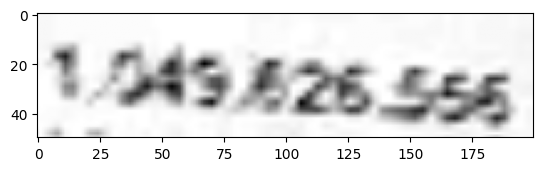

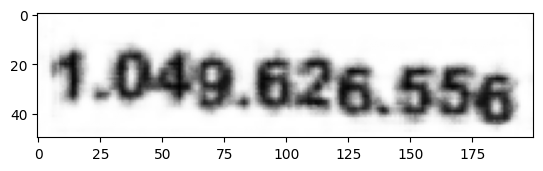

torch.Size([50, 200])
origintal 
generada 1.049.626.556



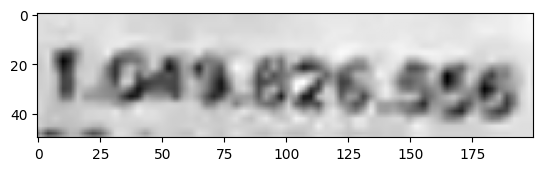

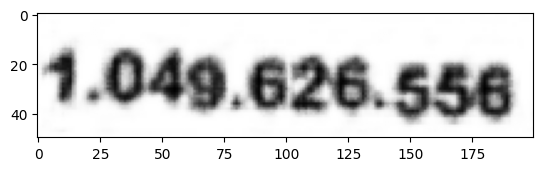

In [ ]:
dataset_ = ReductorRuidoDatasetTest("Dataset")
data_loader_pruebas = DataLoader(dataset_, batch_size=4, shuffle=True)

model = generator.to(device)
model.eval()
with torch.no_grad():
  for noisy_img, _ in data_loader_pruebas:

    # print(noisy_img.max(), noisy_img.min())
    noisy_img = noisy_img.to(device)

    output = model(noisy_img)

    print(output[0][0].shape)

    # Assuming 'output' is a tensor as shown in your code
    # Convert the tensor to a PIL Image
    output_image = output[0][0].cpu().numpy()
    # output_image = noisy_img[0][0].cpu().numpy()
    output_image = (output_image * 255).astype(np.uint8) # Scale to 0-255
    output_image = Image.fromarray(output_image)

    noy_img = noisy_img[0][0].cpu().numpy()
    noy_img = (noy_img * 255).astype(np.uint8) # Scale to 0-255
    noy_img = Image.fromarray(noy_img)

    # Use pytesseract to extract text
    extracted_text = pytesseract.image_to_string(output_image)
    extracted_text_noy = pytesseract.image_to_string(noy_img)

    # Print the extracted text
    print("origintal", extracted_text_noy)
    print("generada", extracted_text)

    output = output.to("cpu")
    noisy_img = noisy_img.to("cpu")

    plt.imshow(noisy_img[0][0], cmap='gray')
    plt.show()

    plt.imshow(output[0][0], cmap='gray')
    plt.show()





    #break

(34, 181)
 



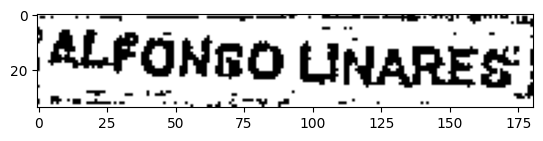

In [ ]:
# prompt: use adatptative binarization and binarize output_image

import numpy as np
import cv2
from PIL import Image


# Assuming 'output_image' is a PIL Image object
#output_image_cv2 = cv2.cvtColor(np.array(output_image), cv2.COLOR_GRAY2BGR)
output_image_cv2 = np.array(output_image)
# Replicate single channel of image, to create second and third channels
#output_image_cv2 = np.repeat(output_image_cv2[:, :, np.newaxis], 3, axis=2)
output_image_cv2 = output_image_cv2.astype(np.uint8)


print(output_image_cv2.shape)

# Adaptive Thresholding
adaptive_threshold = cv2.adaptiveThreshold(output_image_cv2, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 1)



# Convert back to PIL Image for pytesseract
#binarized_image = Image.fromarray(cv2.cvtColor(adaptive_threshold, cv2.COLOR_BGR2GRAY))
binarized_image = Image.fromarray(adaptive_threshold)

# Use pytesseract to extract text from the binarized image
extracted_text = pytesseract.image_to_string(binarized_image)
print(extracted_text)

# plot binarized_image
plt.imshow(binarized_image, cmap='gray')
plt.show()

# ... (rest of your code) ...


In [ ]:
# plot output[0]



In [ ]:
# prompt: extract text from output[0] using tesceract

import numpy as np

import pytesseract
try:
  from PIL import Image
except ImportError:
  import Image

# Assuming 'output' is a tensor as shown in your code
# Convert the tensor to a PIL Image
output_image = output[0][0].cpu().numpy()
# output_image = noisy_img[0][0].cpu().numpy()
output_image = (output_image * 255).astype(np.uint8) # Scale to 0-255
output_image = Image.fromarray(output_image)

# Use pytesseract to extract text
extracted_text = pytesseract.image_to_string(output_image)

# Print the extracted text
extracted_text


In [ ]:
# prompt: load "__AutoEncoder_reduccion_ruido_0.0001_4_.pth" as ConvAutoencoder

mejor_modelo = ConvAutoencoder()
mejor_modelo.load_state_dict(torch.load("__AutoEncoder_reduccion_ruido_0.0001_4_.pth"))
mejor_modelo.eval()
